## VOXPOPULI DATA

In [1]:
import os
import sys
sys.path.append(os.path.abspath("../src"))  
from analysis import extract_pos_tag_scores
from preprocessing import normalize_text
from analysis import load_file, compare_bleu_buckets, calculate_wer_per_sentence, get_knn_gain_outliers, wer_summary
from better_by import (
    load_pickle, classify_sentences,
    extract_pos, extract_entities, plot_distribution
)
import pandas as pd
import matplotlib.pyplot as plt 
from plotting import plot_wer_distribution, plot_knn_gain_scatter

## BLUE BUCKET ANALYSE PER SENTENCE

In [2]:
# Load data 
data_dir = "/Users/sedatgunay/Desktop/compare-mt-2/voxpopuli/"
ref_path = os.path.join(data_dir, "vox_test_ref.txt")
knn_path = os.path.join(data_dir, "vox_test_knn.txt")
van_path = os.path.join(data_dir, "vox_test_van.txt")

# 📄 3. Laad bestanden
refs = load_file(ref_path)
knn = load_file(knn_path)
van = load_file(van_path)

# normalize texts

refs = [normalize_text(line) for line in refs]
knn  = [normalize_text(line) for line in knn]
van = [normalize_text(line) for line in van]

# ✅ Controle: gelijke lengte
assert len(refs) == len(knn) == len(van), "Lengtes van de bestanden komen niet overeen."

# 📊 4. BLEU-bucket edges instellen
bucket_edges = [10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0]

df_bleu = compare_bleu_buckets(refs, knn, van, bucket_edges)

df_bleu.style.background_gradient(cmap="RdYlGn", subset=["Verschil (sys1 - sys2)"])

,BLEU-bucket,Aantal sys1 - kNN-MT,Aantal sys2 - Vanilla,Verschil (sys1 - sys2)
0,"[0.0,10.0)",11,17,-6
1,"[10.0,20.0)",0,0,0
2,"[20.0,30.0)",6,9,-3
3,"[30.0,40.0)",19,25,-6
4,"[40.0,50.0)",35,56,-21
5,"[50.0,60.0)",97,131,-34
6,"[60.0,70.0)",203,244,-41
7,"[70.0,80.0)",361,372,-11
8,"[80.0,90.0)",456,438,18
9,>=90.0,174,150,24


## POS - BUCKET ANALYSE 

In [3]:
html_path = "/Users/sedatgunay/Desktop/compare-mt-2/voxpopuli/comparemt_output_vox_pos/index.html"

print("POS LABEL TAGGING SCORES – VOXPOPULI")
df_voxpopuli_pos = extract_pos_tag_scores(html_path)
display(df_voxpopuli_pos)

POS LABEL TAGGING SCORES – VOXPOPULI


,Label,kNN-MT (sys1),Vanilla (sys2),Verschil (sys1 - sys2)
0,ADJ,0.9233,0.9062,0.0171
1,NOUN,0.8708,0.8365,0.0343
2,PROPN,0.7594,0.7024,0.0570
3,VERB,0.9187,0.9027,0.0160
4,ADV,0.9022,0.8949,0.0073
5,NUM,0.5885,0.5216,0.0669
6,DET,0.9262,0.9225,0.0037
7,PRON,0.8903,0.8742,0.0161
8,ADP,0.9442,0.9392,0.0050
9,CCONJ,0.8860,0.8542,0.0318


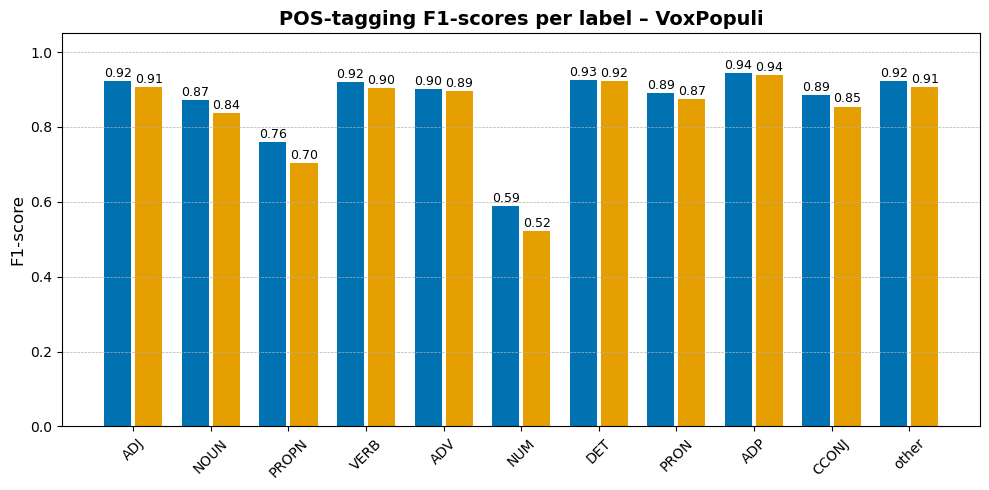

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))

# Kleurenblindvriendelijke kleuren
colors = ["#0072B2", "#E69F00"]

labels = df_voxpopuli_pos["Label"]
x = range(len(labels))
width = 0.35
gap = 0.05

# Plot beide systemen met kleine offset
bars1 = ax.bar([i - gap/2 for i in x], df_voxpopuli_pos["kNN-MT (sys1)"], width, label="kNN-MT", color=colors[0])
bars2 = ax.bar([i + width + gap/2 for i in x], df_voxpopuli_pos["Vanilla (sys2)"], width, label="Vanilla", color=colors[1])

# Waarden bovenop de balken
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f"{height:.2f}", xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', fontsize=9)

# Titels en labels
ax.set_ylabel("F1-score", fontsize=12)
ax.set_title("POS-tagging F1-scores per label – VoxPopuli", fontsize=14, fontweight='bold')
ax.set_xticks([i + width / 2 for i in x])
ax.set_xticklabels(labels, rotation=45, fontsize=10)
ax.set_ylim(0, 1.05)
ax.tick_params(axis='y', labelsize=10)
ax.grid(axis="y", linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.savefig("pos_f1_voxpopuli.png", dpi=300, bbox_inches="tight")
plt.show()

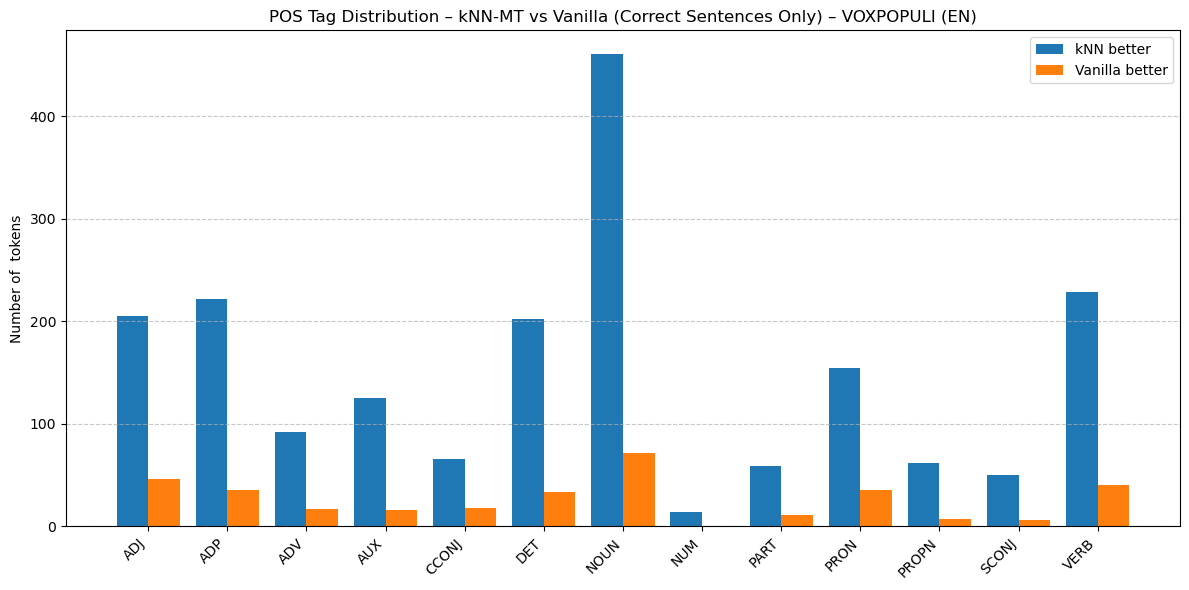

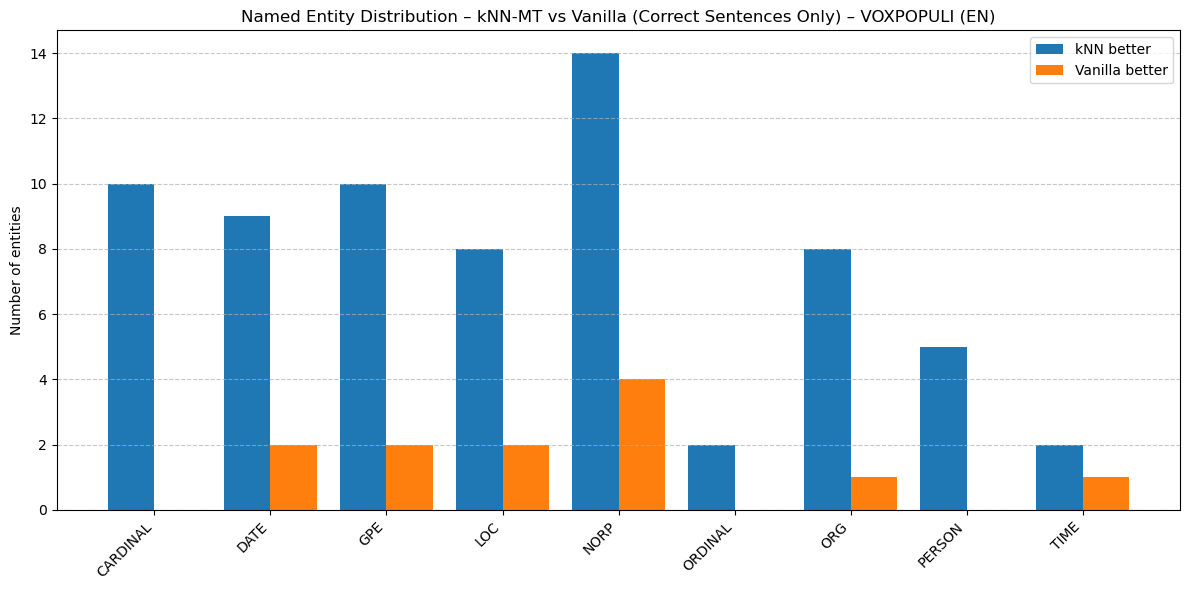

In [12]:
base_path = "/Users/sedatgunay/Desktop/ASR_KNN/dataset data (+outputs)/voxpopuli"
lang = "en"  

# Load data
ref = load_pickle(os.path.join(base_path, "test_ref_texts.pkl"))
knn = load_pickle(os.path.join(base_path, "test_knn_texts.pkl"))
van = load_pickle(os.path.join(base_path, "test_van_texts.pkl"))


ref = [normalize_text(line) for line in ref]
knn  = [normalize_text(line) for line in knn]
van = [normalize_text(line) for line in van]

# Sort better by sentences on systems 
better_knn, better_van = classify_sentences(ref, knn, van)

# POS-tag analysis
pos_knn = extract_pos(better_knn, lang=lang)
pos_van = extract_pos(better_van, lang=lang)
all_pos = sorted(set(pos_knn.keys()).union(pos_van.keys()))

plot_distribution(
    all_pos,
    [pos_knn.get(p, 0) for p in all_pos],
    [pos_van.get(p, 0) for p in all_pos],
    title=f"POS Tag Distribution – kNN-MT vs Vanilla (Correct Sentences Only) – VOXPOPULI ({lang.upper()})",
    ylabel="Number of  tokens"
)

# Entity-analyse
ent_knn = extract_entities(better_knn, lang=lang)
ent_van = extract_entities(better_van, lang=lang)
all_ents = sorted(set(ent_knn.keys()).union(ent_van.keys()))

plot_distribution(
    all_ents,
    [ent_knn.get(e, 0) for e in all_ents],
    [ent_van.get(e, 0) for e in all_ents],
    title=f"Named Entity Distribution – kNN-MT vs Vanilla (Correct Sentences Only) – VOXPOPULI ({lang.upper()})",
    ylabel="Number of entities"
)

## WER ANALYSE

In [6]:
# wer analyses
wer_knn = calculate_wer_per_sentence(ref,knn)
wer_van = calculate_wer_per_sentence(ref,van)

# print means 
print("Mean WER (kNN):", wer_summary(ref,knn)["wer"])
print("Mean WER (van):", wer_summary(ref,van)["wer"])


# Vind zinnen waar kNN significant beter was
gain_outliers = get_knn_gain_outliers(ref, knn, van, threshold=0.2)
gain_indices = [entry[0] for entry in gain_outliers]

# gain_outliers

Mean WER (kNN): 0.1333740858973488
Mean WER (van): 0.15771242273993072


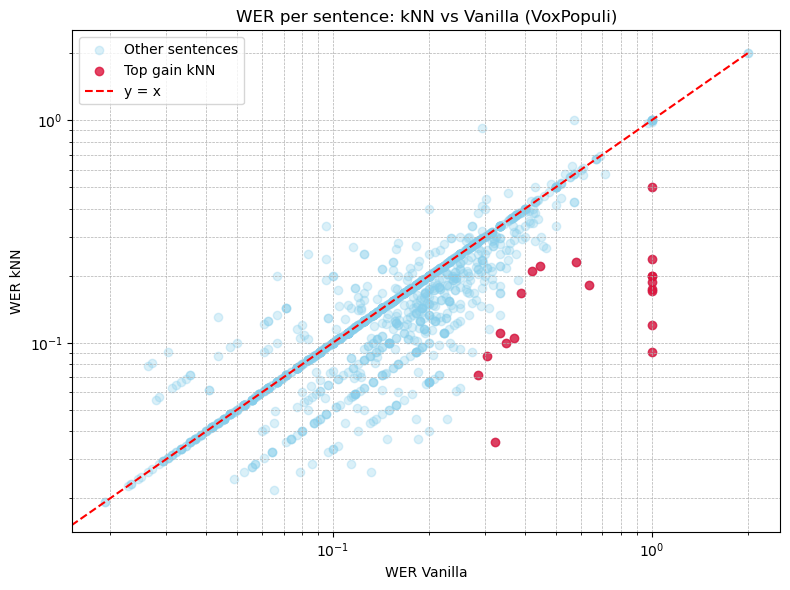

In [7]:
plot_knn_gain_scatter(
    wer_knn, wer_van, gain_indices,
    domain_label="VoxPopuli",
    log_scale=True
)

In [8]:
df_gain = pd.DataFrame(gain_outliers, columns=[
    "Index", "ref", "vanilla", "knn", "wer_vanilla", "wer_knn", "wer_gain_knn"
])

# Sorteer op grootste winst, optioneel
df_gain = df_gain.sort_values(by="wer_gain_knn", ascending=False).reset_index(drop=True)

# Bekijk de eerste rijen
display(df_gain)  


,Index,ref,vanilla,knn,wer_vanilla,wer_knn,wer_gain_knn
0,263,2008. In line with the current debate on ways ...,Thank you.,2008. In line with the current debate on the ...,1.000000,0.090909,0.909091
1,135,the commitment to democratic reform of Ukraine...,Thank you very much.,that the commitment to democratic reform of U...,1.000000,0.120000,0.880000
2,78,on the margins of the current transatlantic ne...,Thank you.,On the margins of the current transatlantic n...,1.000000,0.170213,0.829787
3,573,"I appreciate very much what you said, but can ...",Okay.,"I appreciate very much what you said, but can...",1.000000,0.175000,0.825000
4,251,"Mr President, in the Committee on Budgets, we ...",Thank you.,"In the Committee on Budgets, we voted on more...",1.000000,0.187500,0.812500
5,248,"subject to the codecision procedure and, as we...",Thank you.,and all subjects to the co-decision procedure...,1.000000,0.200000,0.800000
6,1641,I would like to ask you to support this text.,Thank you.,I would like to ask you to support these texts.,1.000000,0.200000,0.800000
7,1121,Only a common EU solution can realistically pr...,Thank you very much.,The Ecomon EU solution can realistically prev...,1.000000,0.238095,0.761905
8,1812,The problem is complex.,is complex.,The problem is complex.,0.500000,0.000000,0.500000
9,1798,this relationship.,This relationship...,This relationship.,1.000000,0.500000,0.500000


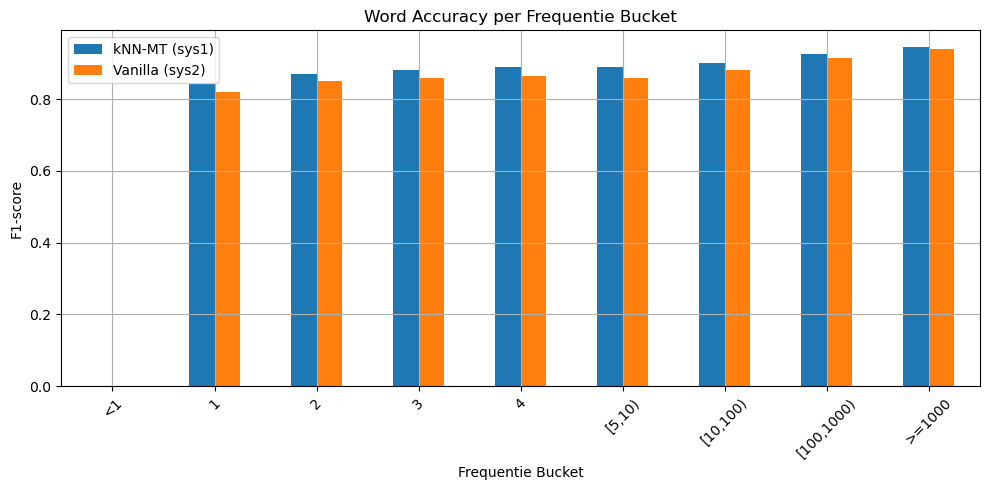

,Frequentie Bucket,kNN-MT (sys1),Vanilla (sys2),Verschil (sys1 - sys2)
0,<1,0.0000,0.0000,0.0000
1,1,0.8414,0.8203,0.0211
2,2,0.8690,0.8505,0.0185
3,3,0.8808,0.8598,0.0210
4,4,0.8889,0.8640,0.0249
5,"[5,10)",0.8885,0.8583,0.0302
6,"[10,100)",0.9020,0.8817,0.0203
7,"[100,1000)",0.9261,0.9157,0.0104
8,>=1000,0.9445,0.9383,0.0062


In [9]:
from analysis import extract_freq_bucket_scores
html_path = "/Users/sedatgunay/Desktop/compare-mt-2/voxpopuli/comparemt_output_freq/index.html"

df_commonvoice_pos_TEST = extract_freq_bucket_scores(html_path)
display(df_commonvoice_pos_TEST)

In [10]:
#save wer knn
save_wer_scores(
    ref_path= ref_path,
    hyp_path=knn_path,
    out_path="results/wer_scores_knn_vox.txt"
)

NameError: name 'save_wer_scores' is not defined

In [ ]:
#save wer van
save_wer_scores(
    ref_path= ref_path,
    hyp_path=van_path,
    out_path="results/wer_scores_van_vox.txt")

In [ ]:

def save_wer_scores(ref_path, hyp_path, out_path):
    # Lees inputbestanden
    with open(ref_path, "r", encoding="utf-8") as f:
        refs = [line.strip() for line in f if line.strip()]
    with open(hyp_path, "r", encoding="utf-8") as f:
        hyps = [line.strip() for line in f if line.strip()]
    
    # Check lengte
    assert len(refs) == len(hyps), "Mismatch in aantal regels tussen ref en hyp"
    
    # Bereken per-zin WER
    results = calculate_wer_per_sentence(refs, hyps)
    wers = [r["wer"] * 100 for r in results]  # schaal naar 0–100%

    # Schrijf naar bestand
    with open(out_path, "w", encoding="utf-8") as f:
        for w in wers:
            f.write(f"{w:.2f}\n")

    print(f"[✓] WER-scores opgeslagen in {out_path}")


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def compare_wer_buckets_two_systems(knn_file, vanilla_file, bucket_size=10, system_names=("kNN", "Vanilla")):
    """
    Vergelijk WER-buckets van twee ASR-systemen.
    
    Parameters:
    - knn_file: pad naar .txt bestand met WER per zin voor kNN-systeem
    - vanilla_file: idem voor vanilla-systeem
    - bucket_size: stapgrootte in procenten (default = 10)
    - system_names: tuple met systeemaanduidingen voor de legenda
    """
    # Laad scores
    with open(knn_file, "r") as f1, open(vanilla_file, "r") as f2:
        knn_scores = [float(l.strip()) for l in f1 if l.strip()]
        vanilla_scores = [float(l.strip()) for l in f2 if l.strip()]

    assert len(knn_scores) == len(vanilla_scores), "Mismatch in aantal zinnen"

    # Definieer buckets
    bins = list(range(0, 101, bucket_size))
    labels = [f"{i}-{i+bucket_size}" for i in bins[:-1]]

    # Tel per bucket
    def count_buckets(scores):
        counts, _ = np.histogram(scores, bins=bins)
        return counts

    knn_counts = count_buckets(knn_scores)
    vanilla_counts = count_buckets(vanilla_scores)

    # Plot
    x = np.arange(len(labels))
    width = 0.35

    plt.figure(figsize=(12, 6))
    plt.bar(x - width/2, vanilla_counts, width, label=system_names[1])
    plt.bar(x + width/2, knn_counts, width, label=system_names[0])
    plt.xticks(x, labels, rotation=45)
    plt.xlabel("WER bucket (%)")
    plt.ylabel("Aantal zinnen")
    plt.title("Vergelijking WER-scoreverdeling: kNN vs Vanilla")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return dict(zip(labels, zip(knn_counts, vanilla_counts)))

In [ ]:
compare_wer_buckets_two_systems(
    knn_file="results/wer_scores_knn_vox.txt",
    vanilla_file="results/wer_scores_van_vox.txt",
    system_names=("kNN-Whisper", "Vanilla Whisper")
)

In [ ]:
def save_wer_scores(ref_path, hyp_path, out_path):
    # Lees inputbestanden
    with open(ref_path, "r", encoding="utf-8") as f:
        refs = [line.strip() for line in f if line.strip()]
    with open(hyp_path, "r", encoding="utf-8") as f:
        hyps = [line.strip() for line in f if line.strip()]
    
    # Check lengte
    assert len(refs) == len(hyps), "Mismatch in aantal regels tussen ref en hyp"
    
    # Bereken per-zin WER
    results = calculate_wer_per_sentence(refs, hyps)
    wers = [r["wer"] * 100 for r in results]  # schaal naar 0–100%

    # Schrijf naar bestand
    with open(out_path, "w", encoding="utf-8") as f:
        for w in wers:
            f.write(f"{w:.2f}\n")

    print(f"[✓] WER-scores opgeslagen in {out_path}")


In [ ]:
compare_wer_buckets_two_systems(
    knn_file="results/wer_scores_knn_com.txt",
    vanilla_file="results/wer_scores_van_com.txt",
    system_names=("kNN-Whisper", "Vanilla Whisper")
)

In [ ]:
compare_wer_buckets_two_systems(
    knn_file="results/wer_scores_knn_libri.txt",
    vanilla_file="results/wer_scores_van_libri.txt",
    system_names=("kNN-Whisper", "Vanilla Whisper")
)

In [ ]:
import pandas as pd

def get_wer_buckets(scores, bucket_edges):
    """
    Buckets WER scores per zin op basis van gespecificeerde grenzen.

    Returns:
    - Dict: bucketlabel → lijst van indexen
    """
    buckets = {}
    for i, score in enumerate(scores):
        for j in range(len(bucket_edges) - 1):
            lower = bucket_edges[j]
            upper = bucket_edges[j + 1]
            label = f"{lower}-{upper}"
            if lower <= score < upper:
                buckets.setdefault(label, []).append(i)
                break
    return buckets

def compare_wer_buckets(scores_knn, scores_vanilla, bucket_edges):
    """
    Vergelijk verdeling van WER-scores over buckets tussen twee systemen.

    Parameters:
    - scores_knn (List[float]): WER-scores (0–100%) voor kNN.
    - scores_vanilla (List[float]): idem voor vanilla.
    - bucket_edges (List[float]): Grenzen van de buckets (bijv. [0, 10, ..., 100])

    Returns:
    - pd.DataFrame: Bucketlabel, aantallen per systeem en verschil.
    """
    buckets_knn = get_wer_buckets(scores_knn, bucket_edges)
    buckets_vanilla = get_wer_buckets(scores_vanilla, bucket_edges)

    rows = []
    all_labels = sorted(set(buckets_knn.keys()) | set(buckets_vanilla.keys()))
    for label in all_labels:
        count_knn = len(buckets_knn.get(label, []))
        count_vanilla = len(buckets_vanilla.get(label, []))
        diff = count_knn - count_vanilla
        rows.append((label, count_knn, count_vanilla, diff))

    df = pd.DataFrame(rows, columns=[
        "WER-bucket",
        "Aantal kNN-Whisper",
        "Aantal Vanilla",
        "Verschil (kNN - Vanilla)"
    ])
    return df

In [ ]:
# Lees je per-sentence WER-scores in
with open("results/wer_scores_knn_vox.txt") as f:
    knn_scores = [float(line.strip()) for line in f]

with open("results/wer_scores_van_vox.txt") as f:
    vanilla_scores = [float(line.strip()) for line in f]

# Definieer bucketranden
edges = list(range(0, 110, 10))  # [0,10,20,...,100]

# Maak dataframe
df_wer_buckets = compare_wer_buckets(knn_scores, vanilla_scores, edges)
print(df_wer_buckets)

In [ ]:
# Lees je per-sentence WER-scores in
with open("results/wer_scores_knn_com.txt") as f:
    knn_scores = [float(line.strip()) for line in f]

with open("results/wer_scores_van_com.txt") as f:
    vanilla_scores = [float(line.strip()) for line in f]

# Definieer bucketranden
edges = list(range(0, 110, 10))  # [0,10,20,...,100]

# Maak dataframe
df_wer_buckets = compare_wer_buckets(knn_scores, vanilla_scores, edges)
print(df_wer_buckets)

In [ ]:
# Lees je per-sentence WER-scores in
with open("results/wer_scores_knn_libri.txt") as f:
    knn_scores = [float(line.strip()) for line in f]

with open("results/wer_scores_van_libri.txt") as f:
    vanilla_scores = [float(line.strip()) for line in f]

# Definieer bucketranden
edges = list(range(0, 110, 10))  # [0,10,20,...,100]

# Maak dataframe
df_wer_buckets = compare_wer_buckets(knn_scores, vanilla_scores, edges)
print(df_wer_buckets)

In [ ]:
def save_wer_scores(ref_path, hyp_path, out_path, normalize=True):
    """
    Bereken per-zin WER en sla op in een bestand. Optioneel met normalisatie.

    Parameters:
        ref_path (str): pad naar referentiebestand (.txt)
        hyp_path (str): pad naar hypothesebestand (.txt)
        out_path (str): pad naar outputbestand voor WER-scores
        normalize (bool): of normalisatie toegepast moet worden (default = True)
    """
    # Lees inputbestanden
    with open(ref_path, "r", encoding="utf-8") as f:
        refs = [line.strip() for line in f if line.strip()]
    with open(hyp_path, "r", encoding="utf-8") as f:
        hyps = [line.strip() for line in f if line.strip()]

    # Check lengte
    assert len(refs) == len(hyps), "Mismatch in aantal regels tussen ref en hyp"

    # Optioneel: normaliseer
    if normalize:
        refs = [normalize_text(line) for line in refs]
        hyps = [normalize_text(line) for line in hyps]

    # Bereken per-zin WER
    results = calculate_wer_per_sentence(refs, hyps)
    wers = [r["wer"] * 100 for r in results]  # schaal naar 0–100%

    # Schrijf naar bestand
    with open(out_path, "w", encoding="utf-8") as f:
        for w in wers:
            f.write(f"{w:.2f}\n")

    print(f"[✓] WER-scores opgeslagen in {out_path}")

In [ ]:
#save wer vanilla
save_wer_scores(
    ref_path= ref_path,
    hyp_path= van_path,
    out_path="results/wer_scores_van_vox.txt",
    normalize= True
)

#save wer vanilla
save_wer_scores(
    ref_path= ref_path,
    hyp_path= knn_path,
    out_path="results/wer_scores_knn_vox.txt",
    normalize = True
)




In [ ]:
# Lees je per-sentence WER-scores in
with open("results/wer_scores_knn_com_num.txt") as f:
    knn_scores = [float(line.strip()) for line in f]

with open("results/wer_scores_van_com_num.txt") as f:
    vanilla_scores = [float(line.strip()) for line in f]

# Definieer bucketranden
edges = list(range(0, 110, 10))  # [0,10,20,...,100]

# Maak dataframe
df_wer_buckets = compare_wer_buckets(knn_scores, vanilla_scores, edges)
print(df_wer_buckets)